
# Data Pipeline: Monitoring and Scaling

![Illustration](https://cdn.prod.website-files.com/5f20e5165df603bb1fc5f0fb/64e10eaf3df2a4e609244257_og_etl-dashboard.png)

### Monitoring Tracking for each ELT
- **Real-Time Tracking:**  
  Use dashboards to continuously monitor metrics such as latency, throughput, and error rates.
- **Logging & Alerts:**  
  Collect detailed logs from each component and set up automated alerts to quickly address issues.

```python
log_sql = f"""
    INSERT INTO config_db.elt_process_log 
    (log_id, process_name, target_table, start_time, end_time, execution_time_seconds, size, rows_affected, status) 
    VALUES (last_log_id, 'Data Ingestion', '{table_name}', '{start_time}', '{end_time}', {exec_time}, '{file_size_mb:.2f} MB', {record_count}, 'Success')
"""
```

- **Ongoing Effort:**  
  Regular reviews, proactive troubleshooting, and continuous improvements ensure that our monitoring adapts to changing conditions.

### Scaling based on file size to manage horizontal scaling
**Horizontal Scaling:**  
  Add processing nodes and use load balancers to distribute workloads evenly.  
  
 - **Peak vs. Off-Peak Mode**:
  - **Peak Mode**: If file size > 1GB, increases parallelism for faster processing.
  - **Off-Peak Mode**: Optimized resource usage for smaller files.
  
```python

file_size_mb = os.path.getsize(row.file_path) / (1024 * 1024)
    load_condition = "peak" if file_size_mb > PEAK_THRESHOLD_MB else "off-peak"
    
    if load_condition == "peak":
        spark.conf.set("spark.sql.shuffle.partitions", "500")
        print(f"⚡ Peak Load for {table_name} ({file_size_mb:.2f} MB). High parallelism applied.")
    else:
        spark.conf.set("spark.sql.shuffle.partitions", "100")
        print(f"🌙 Off-Peak Load for {table_name} ({file_size_mb:.2f} MB). Optimized resource usage.")
    
    df.withColumn("ingestion_date", lit(ingestion_date)).write.mode("overwrite").partitionBy("ingestion_date").parquet(os.path.join(parquet_base_path, table_name))
```


While the best practices above provide a comprehensive framework, for simplicity we implement a streamlined solution using the following Python script to monitor key ETL performance metrics:

## Dashboard Overview

1. **Raw Data Preview:**  
   Quick snapshot of ETL logs for initial data quality check.

2. **Data Normalization:**  
   Standardize method names for accurate grouping.

3. **Aggregated Summary:**  
   Table showing total runs, average execution time, and failure rates.

4. **Bar Chart:**  
   Visual comparison of average execution times per method.

5. **Detailed Table:**  
   Precise view of all key metrics.

*Benefit:* Provides clear insights to quickly identify and address performance issues.




--- Sneak Peek: Raw Method Data ---
         method_used  total_runs  avg_execution_time  failures
    DataFrame (Peak)           3          340.631527         0
    DataFrame (peak)           2           21.924413         0
DataFrame (Off-peak)           7           19.205331         1
DataFrame (off-peak)           2           15.804188         0
  Data Quality Check          10           14.897225        10

--- Aggregated ETL Method Performance Summary ---
   method_normalized  total_runs  avg_execution_time  failures  failure_percentage
  data quality check          10           14.897225        10          100.000000
dataframe (off-peak)           9           17.504759         1           11.111111
    dataframe (peak)           5          181.277970         0            0.000000


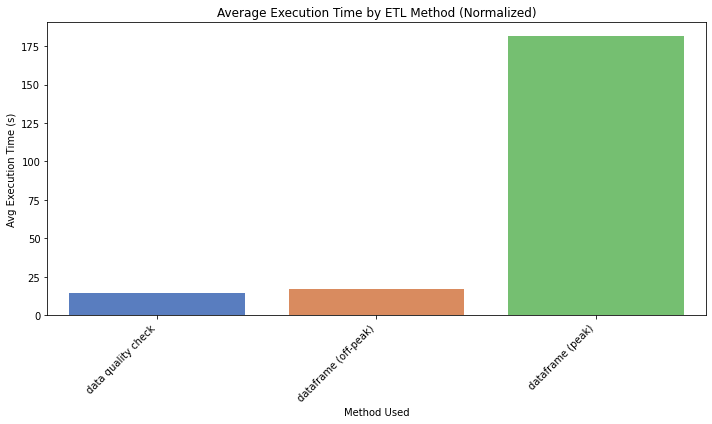

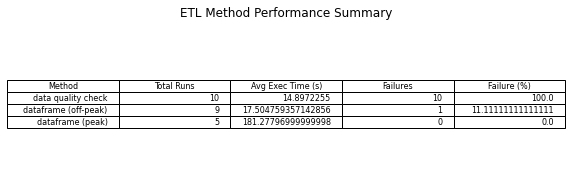

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# =============================================================================
# PART: Analysis by method_used (including graph)
# =============================================================================
# Aggregate performance metrics by method_used.
query_method = """
SELECT 
    method_used,
    COUNT(*) AS total_runs,
    AVG(execution_time_seconds) AS avg_execution_time,
    SUM(CASE WHEN upper(status) != 'SUCCESS' THEN 1 ELSE 0 END) AS failures
FROM config_db.elt_process_log
GROUP BY method_used
ORDER BY avg_execution_time DESC
"""

# Execute the query and load the results into a Pandas DataFrame.
df_method = spark.sql(query_method).toPandas()

# Sneak Peek: Show the raw method data.
print("\n--- Sneak Peek: Raw Method Data ---")
print(df_method.head().to_string(index=False))

# Normalize the method_used values to group similar ones together.
df_method["method_normalized"] = df_method["method_used"].str.lower().str.strip()

# Now, aggregate metrics by the normalized method.
df_method_grouped = df_method.groupby("method_normalized").agg({
    "total_runs": "sum",
    "avg_execution_time": "mean",
    "failures": "sum"
}).reset_index()

# Calculate failure percentage.
df_method_grouped["failure_percentage"] = 100 * df_method_grouped["failures"] / df_method_grouped["total_runs"]

# Print the aggregated summary.
print("\n--- Aggregated ETL Method Performance Summary ---")
print(df_method_grouped.to_string(index=False))

# =============================================================================
# Visualization: Bar Chart of Average Execution Time by Normalized Method
# =============================================================================
plt.figure(figsize=(10, 6))
sns.barplot(data=df_method_grouped, x="method_normalized", y="avg_execution_time", palette="muted")
plt.title("Average Execution Time by ETL Method (Normalized)")
plt.xlabel("Method Used")
plt.ylabel("Avg Execution Time (s)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# =============================================================================
# Tabular Visualization using Matplotlib Table
# =============================================================================
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('tight')
ax.axis('off')
table_data_method = df_method_grouped.copy()
table_data_method.columns = ["Method", "Total Runs", "Avg Exec Time (s)", "Failures", "Failure (%)"]
ax.table(cellText=table_data_method.values, colLabels=table_data_method.columns, loc='center')
plt.title("ETL Method Performance Summary")
plt.show()


Data Quality Log:
<Figure size 864x432 with 0 Axes>

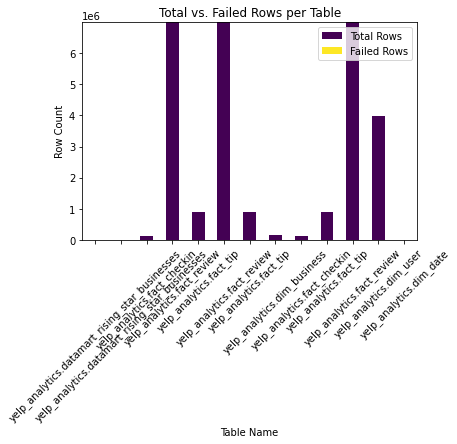

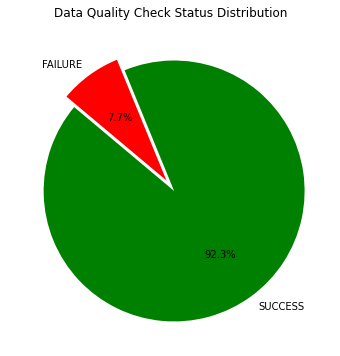

=== Sneak Peek: Derived ETL Metrics ===
 InputSize  ProcessingTime  Throughput  MemoryUsage
         0        2.621184    0.000000          NaN
         0       34.927690    0.000000          NaN
    150346       24.051205 6251.079728          NaN
    131930       26.743393 4933.181066          NaN
    150346       21.911079 6861.642916          NaN


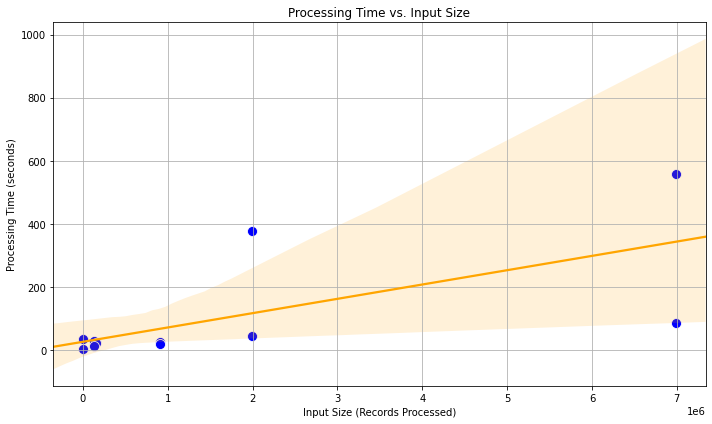

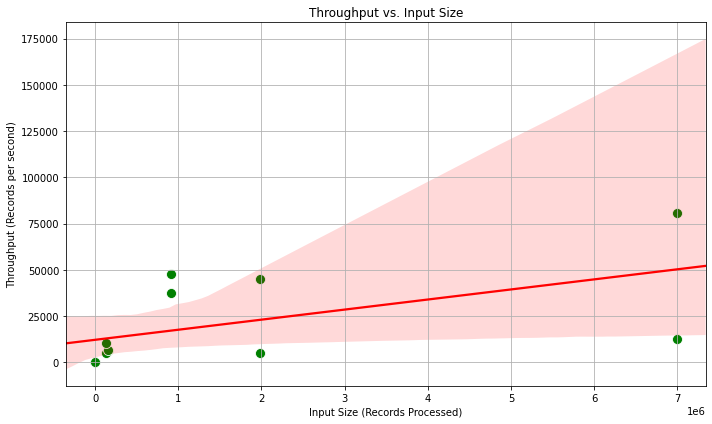

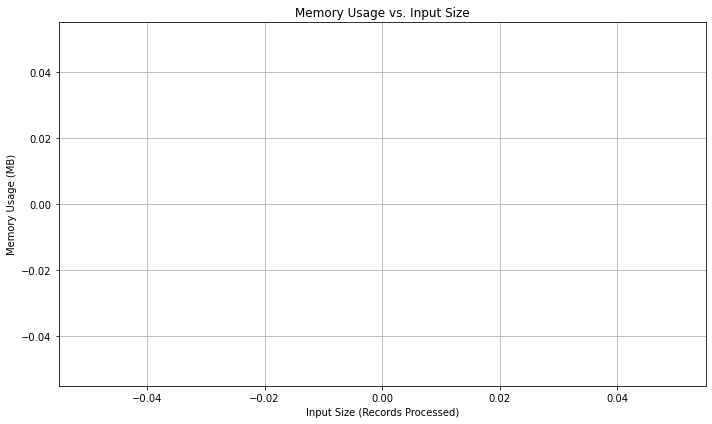

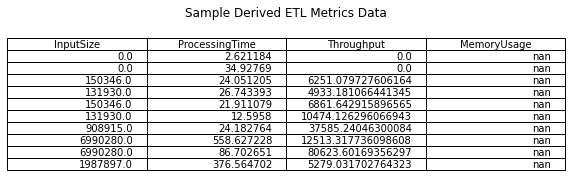

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# -----------------------------------------------------------------------------
# PART 1: Derive Key Metrics from the ETL Logs
# -----------------------------------------------------------------------------
# We derive:
# - InputSize: rows_affected (number of records processed)
# - ProcessingTime: execution_time_seconds
# - Throughput: rows_affected / execution_time_seconds
# - MemoryUsage: cast(size as double) assuming the value is in MB

query_derived = """
SELECT 
    rows_affected AS InputSize,
    execution_time_seconds AS ProcessingTime,
    CASE 
      WHEN execution_time_seconds > 0 THEN rows_affected / execution_time_seconds 
      ELSE 0 
    END AS Throughput,
    CAST(size AS DOUBLE) AS MemoryUsage
FROM config_db.elt_process_log
WHERE size IS NOT NULL AND rows_affected IS NOT NULL
"""

# Execute the query and convert the result to a Pandas DataFrame.
df_metrics = spark.sql(query_derived).toPandas()

# Sneak peek: show the first few rows of the derived metrics.
print("=== Sneak Peek: Derived ETL Metrics ===")
print(df_metrics.head().to_string(index=False))

# -----------------------------------------------------------------------------
# PART 2: Visualizations
# -----------------------------------------------------------------------------
# Visualization 1: Processing Time vs. Input Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metrics, x="InputSize", y="ProcessingTime", s=100, color="blue")
sns.regplot(data=df_metrics, x="InputSize", y="ProcessingTime", scatter=False, color="orange", truncate=False)
plt.title("Processing Time vs. Input Size")
plt.xlabel("Input Size (Records Processed)")
plt.ylabel("Processing Time (seconds)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization 2: Throughput vs. Input Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metrics, x="InputSize", y="Throughput", s=100, color="green")
sns.regplot(data=df_metrics, x="InputSize", y="Throughput", scatter=False, color="red", truncate=False)
plt.title("Throughput vs. Input Size")
plt.xlabel("Input Size (Records Processed)")
plt.ylabel("Throughput (Records per second)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualization 3: Memory Usage vs. Input Size
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_metrics, x="InputSize", y="MemoryUsage", s=100, color="purple")
sns.regplot(data=df_metrics, x="InputSize", y="MemoryUsage", scatter=False, color="brown", truncate=False)
plt.title("Memory Usage vs. Input Size")
plt.xlabel("Input Size (Records Processed)")
plt.ylabel("Memory Usage (MB)")
plt.grid(True)
plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# PART 3: Tabular Visualization of Sample Derived Data
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis("tight")
ax.axis("off")
sample_data = df_metrics.head(10)
ax.table(cellText=sample_data.values, colLabels=sample_data.columns, loc='center')
plt.title("Sample Derived ETL Metrics Data")
plt.show()
